# Transfer Learning with VGG16

In [1]:
import torch
import torch.nn.functional as  F
from torch import nn, optim
from torchvision import datasets, models
import torchvision.transforms.v2 as transforms

/apps/daint/UES/6.0.UP04/sandboxes/sarafael/ml2024/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/apps/daint/UES/6.0.UP04/sandboxes/sarafael/ml2024/lib/python3.9/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import numpy as np

In [4]:
from tqdm import trange

In [5]:
import copy

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
import os
from functools import partial

## VGG16

VGG16 is a CNN for image classification, the runner-up in the [ImageNet]() competition in 2015. A pre-trained VGG16 model can be easily downloaded from `torchvision.models`, with the `DEFAULT` pre-trained weights.

In [8]:
model = models.vgg16(weights='DEFAULT')

Printing the model will display the model architecture:

In [9]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

*Have a look at the model. You should be able to recognise almost all the layers of this CNN. What `AdaptiveAvgPool2d` does? Why it is useful?*

We can see that the full model is composed of two `nn.Sequential` sub-modules: `features` and `classifier`. The `features` sub-module is composed of convolutional layers and acts as a feature extraction module. The `classifier` sub-module is composed of linear layers and acts as a classifier.

Using transfer learning, we are interested in tuning the model for classification of flowers.

## Data Set

For this exercise, we use the [tf_flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers) data set. Extracting the data will take a while...

In [10]:
%%bash
if [ -d ./data/flower_photos ]; then
  echo "Directory exists"
else
    wget http://download.tensorflow.org/example_images/flower_photos.tgz -P ./data/
    cd data/ && tar xfz flower_photos.tgz
    rm -f flower_photos/LICENSE.txt
fi

Directory exists


The data set consists of 3670 images of 5 flower classes: daisy, dandelion, roses, sunflowers, and tulips.

*Check if any of these classes were already present in the original ImageNet data set, on which VGG-16 has been trained.*

### Data Transformation

*Read [PyTorch documentation for VGG16]() and determine the mean and standard deviation needed to normalise the images, as well as the size of the input images. Define a transformation that `RandomResizedCrop` the input images to the correct size, and normalise them. Use the `ToImage()` transform to convert images to tensors, and use `ToDtype(torch.float32, scale=True)` to convert the data for `float32` before normalisation.* `RandomResizeCrop` allows to crop the images to the correct input size, while adding a bit of data augmentation.

In [11]:
# TODO
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


transform = transforms.Compose([
    transforms.ToImage(),
    # RandomResizeCrop to the correct size for VGG-16
    # TODO
    transforms.RandomResizedCrop(224, antialias=True), 
    transforms.ToDtype(torch.float32, scale=True),
    # Normalize input
    # TODO
    transforms.Normalize(mean=mean,std=std)
])

### Loading the Data Set

 The data set is structured in sub-folders named after the classes of flowers.

In [12]:
dataroot = f"{os.getcwd()}/data/flower_photos"
print(dataroot)

/users/class402/cscs-deep-learning/more_on_training/data/flower_photos


In [13]:
! ls -l data/flower_photos

total 640
drwx------ 2 class402 class08 65536 Feb 10  2016 daisy
drwx------ 2 class402 class08 65536 Feb 10  2016 dandelion
drwx------ 2 class402 class08 65536 Feb 10  2016 roses
drwx------ 2 class402 class08 65536 Feb 10  2016 sunflowers
drwx------ 2 class402 class08 65536 Feb 10  2016 tulips


 The [`ImageFolder`](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) class allows to easily load such dataset:

In [14]:
dataset = datasets.ImageFolder(dataroot, transform=transform)

The amount of data in this dataset is not very large, therefore transfer learning is a very convenient technique:

In [15]:
print(f"Number of images: {len(dataset)}")

Number of images: 3670


We now split the data set into a training set and a validation set. For simplicity, we skip the creation of a separate test set (something you shouldn't do!).

In [16]:
n = len(dataset)
idx_train, idx_valid = train_test_split(np.arange(n), test_size=0.2, random_state=42)

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(idx_train)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(idx_valid)

In [17]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

*Create a function doing all of the above, for convenient re-use.*

In [18]:
def create_dataset(batch_size, dataroot="data/flower_photos"):
    # Define mean and standard deviation for normalisation
    # TODO
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Define the transform
    # TODO
    transform = transforms.Compose([
        transforms.ToImage(), # Convert PIL image to tensor
        transforms.RandomResizedCrop(224, antialias=True), 
        # scale=True re-scale according to dtype
        # integer dtype: [0, 255]
        # float dtype: [0, 1]
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=mean,std=std)
    ])
    
    dataset = datasets.ImageFolder(dataroot, transform=transform)
    
    n = len(dataset)
    idx_train, idx_valid = train_test_split(np.arange(n), test_size=0.2, random_state=42)

    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(idx_train)
    valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(idx_valid)
    
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    validloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return trainloader, validloader

#### Visualizing Images and Labels

First, let's define a dictionary mapping labels (numbers from 0 to 4 denoting one of the flower classes) to the acutal classes names:

In [19]:
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

label_to_name = { 
    i : name 
    for i, name in enumerate(classes) 
}

print(label_to_name)

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}


Then we can visualise a batch of images. PyTorch stores images with in the `C x H x W` convention (where C is number of channels, H the image height and W the image width) while `matplotlib` uses the `H x W x C` convention. This means that we have to transpose our tensor from `C x H x W` to  `H x W x C`.

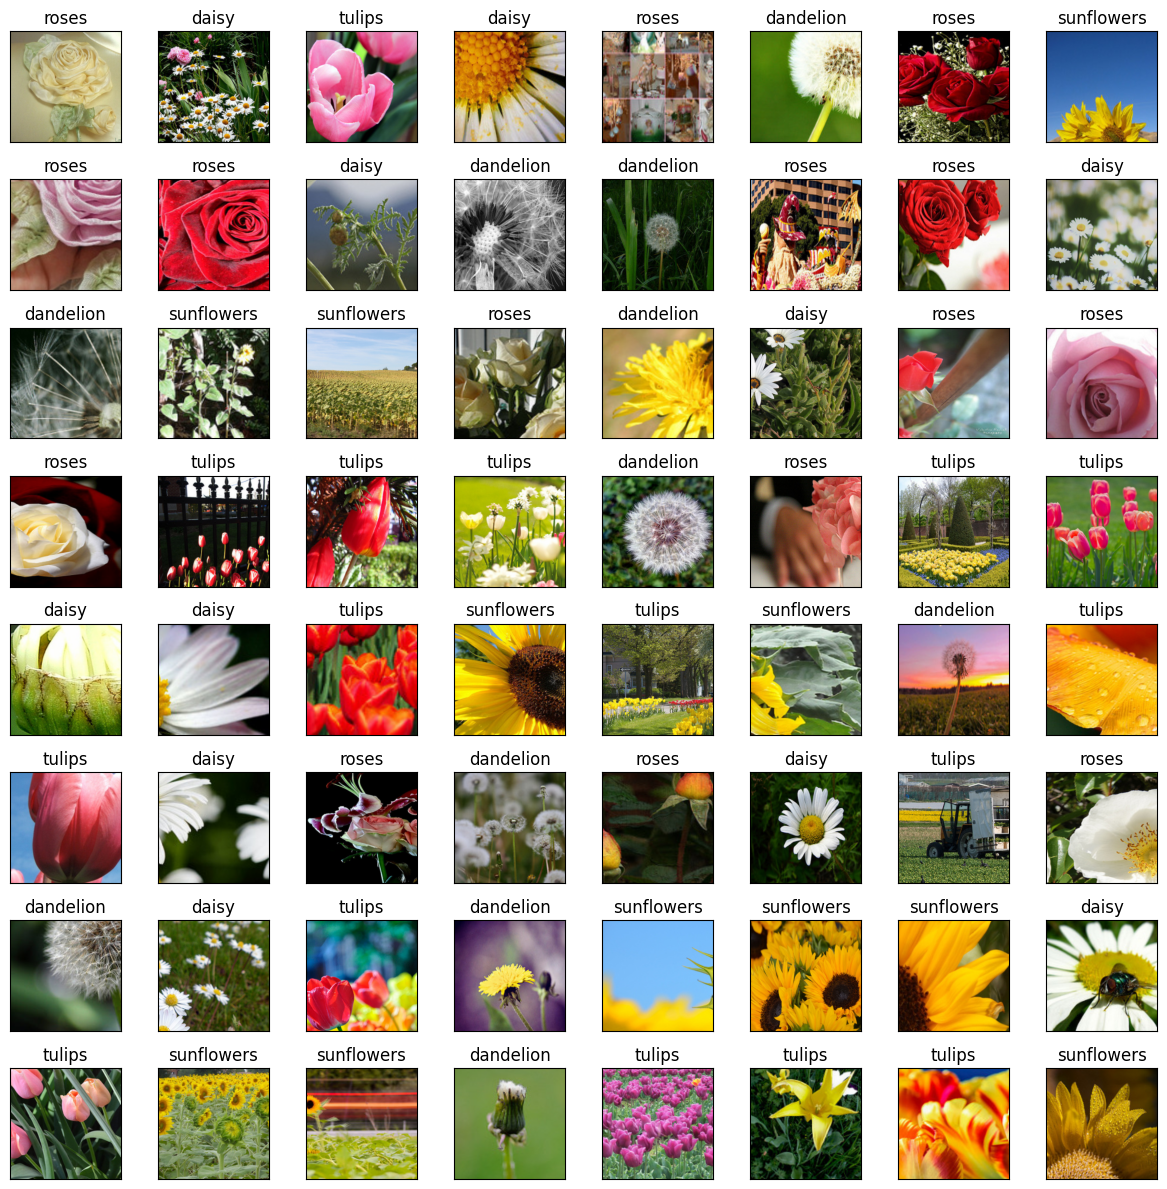

In [20]:
trainiter = iter(trainloader)
images, labels = next(trainiter)

fig = plt.figure(figsize=(12,12))
for idx in range(64):
    ax = fig.add_subplot(8, 8, idx + 1, xticks=[], yticks=[])
    
    # Un-normalize image
    img = images[idx].numpy().squeeze()
    for i in range(3):
        img[i,:,:] = img[i,:,:] * std[i] + mean[i]

    # Transpose image from C x H x W to H x W x C
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
    # Get name
    name = label_to_name[labels[idx].item()]
    
    ax.set_title(name, fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()

*Run the previous cell a few times. How does the dataset looks like?*

## Adapting Pre-Trained VGG-16

We already downloaded the VGG16 model from `torchvision.models` above, with `DEFAULT` pre-trained weights. In order to use this model for classification of flowers, we need two things:
* Freeze the model parameters of the layers we do not want to train
* Replace the last fully connected layer with a layer with the correct number of output classes (`5`)

The VGG16 architecture is the following:

In [21]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

*Create a function taking an integer `layer_size` that:*
* _Defines a VGG16 model with pre-trained weights_
* _Freezes the weights of all layers_
* _Substitutes the last two pre-trained linear layers with new (untrained) linear layers_

*The last linear layer needs the number of classes as output, while the input of the last linear layer should be parametrized by `layer_size`.*

In [22]:
def create_model(layer_size):
    model = models.vgg16(weights='DEFAULT')
    
    # Freeze all model parameters
    # TODO
    for param in model.parameters():
        param.requires_grad = False
        
    # It is possible to only freexe the features layers
    #for param in model.features.parameters():
    #    param.requires_grad = False
    
    # Substitute the last two linear layers 
    # TODO
    model.classifier[3] = nn.Linear(model.classifier[3].in_features, layer_size)
    model.classifier[6] = nn.Linear(layer_size, len(classes))
    
    return model

Let's check that the `create_model` function works as expected:

In [23]:
create_model(1024)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Training

*Complete the training function defined below, assuming that the `params` dictionary contains the following entries:*
* `layer_size`
* `batch_size`
* `lr` _(learning rate)_
* `n_epochs`

Finally we can train our network as usual. The `require_grad=False` parameter for the frozen layers will prevent the optimiser to change the weights and biases of those layer. Effectively, only the last linear layer we modified will be trained.

In [24]:
def train_fn(params, dataroot="data/flower_photos"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Create a model using the "create_model" function
    # TODO
    model = create_model(params["layer_size"])
     
    model.to(device)
    
    # Create data loaders using the "create_dataset" function
    # TODO
    trainloader, validloader = create_dataset(batch_size=params["batch_size"], dataroot=dataroot)
    
    # Define an appropriate loss function
    # TODO
    loss_function = nn.CrossEntropyLoss()
    
    # Define an Adam optimizer
    # TODO
    optimizer = optim.Adam(model.parameters(), lr=params["lr"])
    
    best_valid_loss = np.inf
    best_accuracy = np.inf
    
    pbar = trange(params["n_epochs"], desc='Training', leave=True)
    for epoch in pbar:
        epoch_loss = 0

        # Ensure model is in training mode
        # TODO
        model.train()
        
        for images, labels in trainloader:

            # Move data to GPU
            # TODO
            images, labels = images.to(device), labels.to(device)
        
            # Initialize optimizer gradients to zero
            # TODO
            optimizer.zero_grad()
            
            # Perform forward pass
            # TODO
            output = model(images)
            
            # Compute the loss
            # TODO
            loss = loss_function(output, labels)
            
            # Perform backpropagation
            # TODO
            loss.backward()
            
            # Update model weights
            # TODO
            optimizer.step()
            
            epoch_loss += loss.item()
            
        valid_loss = 0
        accuracy = 0

        with torch.no_grad():

            # Ensure model is in evaluation mode
            # TODO
            model.eval()

            for images, labels in validloader:

                # Move data to GPU
                # TODO
                images, labels = images.to(device), labels.to(device)
                    
                # Perform forward pass
                # TODO
                output = model(images)
                    
                # Compute the loss
                valid_loss += loss_function(output, labels).item()
                    
                # Compute class probabilities
                # TODO
                p = torch.exp(output)
                
                # Compute accuracy
                top_p, top_c = p.topk(1, dim=1) # Top prediction
                equals = (top_c == labels.view(*top_c.shape)).type(torch.FloatTensor)
                accuracy += torch.mean(equals)
                    
        t_loss = epoch_loss/len(trainloader)
        v_loss = valid_loss/len(validloader)
        acc = accuracy.item()/len(validloader)*100
        
        # Store best model (perform a deep copy of the state dictionary)
        # TODO 
        if v_loss < best_valid_loss:
            best_state_dict = copy.deepcopy(model.state_dict())
            best_valid_loss = v_loss
            best_accuracy = acc
            
        pbar.set_postfix({"Accuracy": acc})
            
    # Load best model at the end of training
    # TODO
    model.load_state_dict(best_state_dict)
            
    return model.eval(), best_accuracy

Let's train with the following parameters:

In [25]:
params = {
    "layer_size": 1024,
    "lr": 0.005,
    "batch_size": 128,
    "n_epochs": 10
}

In [26]:
model, acc = train_fn(params)

Training: 100%|██████████| 10/10 [07:48<00:00, 46.90s/it, Accuracy=90.3]


*If you finish early, you can try to re-run the notebook whit less frozen parameters and study the impact on accuracy and training time. If time allows it, play around with the hyperparameters of the model and see if you can obtain a better accuracy on the validation set.*

*This notebooks has been structured in such a way that the training function is self-contained. This allows to adapt it to a framework for hyperparameter tuning.*